---
title: 그래픽스 공부 2. pipeline
categories: [study]
comments: true
---

## 선 그리기

우선 공간상에 선을 그려보자.

처음으로 사용할 알고리즘은 선으로부터 0.5 거리 이내의 점들을 하얗게 칠하는 방법이다.

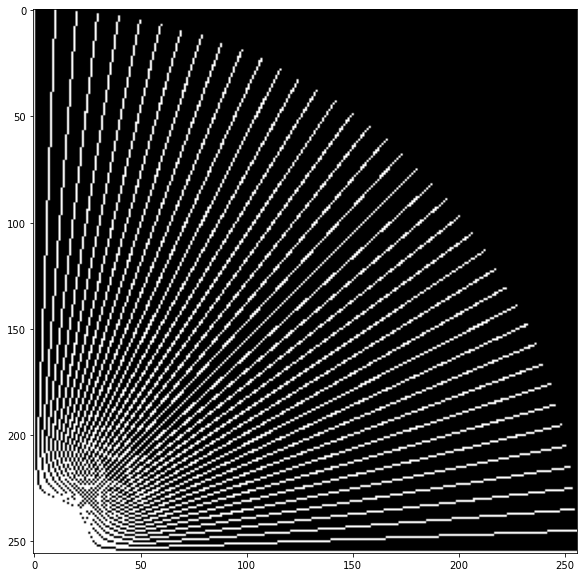

In [1]:
import numpy as np
import matplotlib.pyplot as plt

img = np.zeros(shape=(256, 256, 3))

def draw_line(p0, p1):
    d = p1 - p0
    d /= np.linalg.norm(d)
    for i in range(500):
        a = i / 499.0
        p = (1 - a) * p0 + a * p1
        pi = np.rint(p).astype(np.int32)
        q = np.dot(d, pi - p0) * d
        dist = np.linalg.norm(q - pi)
        if dist < 0.5:
            img[pi[1], pi[0], :] = 1.0


for i in range(41):
    i = i / 40.0
    c = np.cos(np.pi * 0.5 * i)
    s = np.sin(np.pi * 0.5 * i)
    draw_line(np.array([0.0, 0.0]), np.array([c, s]) * 255)
    
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])

위의 사진을 보면 알겠지만, 선으로 부터 0.5 거리 이하인 점들을 하얗게 칠하는 랜더링 방법은

상당히 예쁘지 못한 결과를 만들어낸다.

다음은 Bresenham line algorithm (Midpoint line algorithm)이라는 알고리즘으로 랜더링을 해본다.

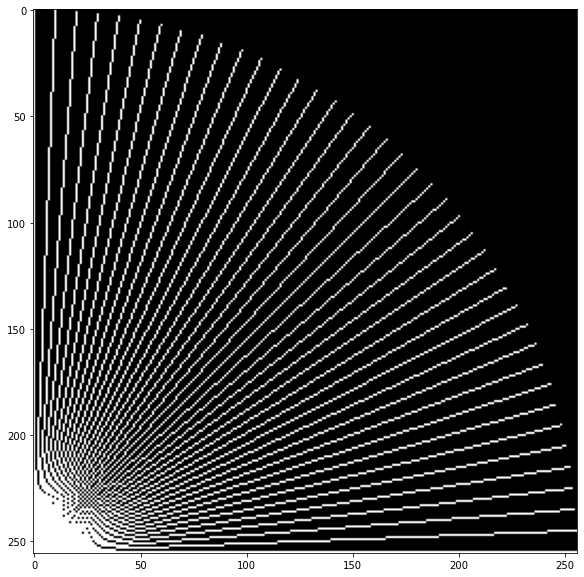

In [2]:
img = np.zeros(shape=(256, 256, 3))

def draw_line(p0, p1):
    dp = p1 - p0
    is_hor = np.abs(dp[0]) > np.abs(dp[1])
    sp = np.rint(p0).astype(np.int32)
    tp = np.rint(p1).astype(np.int32)
    si = sp[0] if is_hor else sp[1]
    ti = tp[0] if is_hor else tp[1]
    if is_hor:
        if dp[0] > 0:
            di = 1
        else:
            di = -1
    else:
        if dp[1] > 0:
            di = 1
        else:
            di = -1
    
    sx = p0[0] if is_hor else p0[1]
    sy = p0[1] if is_hor else p0[0]
    r = dp[1] / dp[0] if is_hor else dp[0] / dp[1]
    
    for x in range(si, ti + di, di):
        y = (x - sx) * r + sy
        y = np.rint(y).astype(np.int32)
        if is_hor:
            img[y, x, :] = 1.0
        else:
            img[x, y, :] = 1.0


for i in range(41):
    i = i / 40.0
    c = np.cos(np.pi * 0.5 * i)
    s = np.sin(np.pi * 0.5 * i)
    draw_line(np.array([0.0, 0.0]), np.array([c, s]) * 255)
    
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])

제법 괜찮은 결과가 나온다. 하지만 곱셈과 rounding 연산은 느리다고 한다.

좀 더 최적화가 가능하다.

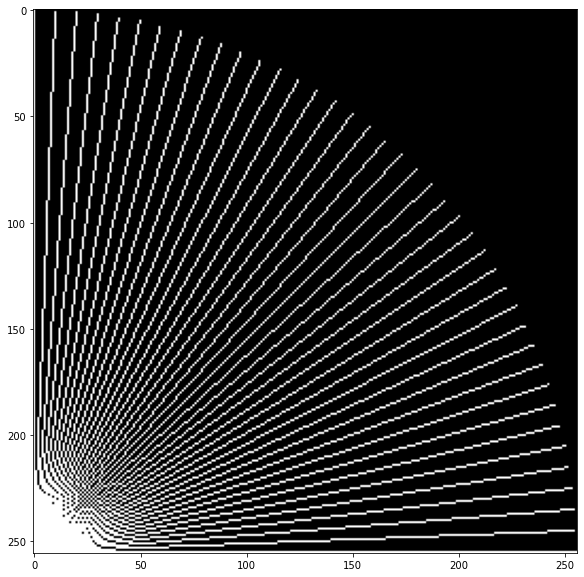

In [3]:
img = np.zeros(shape=(256, 256, 3))

def get_line_pixels(p0, p1):
    dp = p1 - p0
    m = np.zeros(shape=(2, 2))
    if np.abs(dp[0]) > np.abs(dp[1]):
        m[0, 0] = 1.0 if p0[0] < p1[0] else -1.0
        m[1, 1] = 1.0 if p0[1] < p1[1] else -1.0
    else:
        m[1, 0] = 1.0 if p0[1] < p1[1] else -1.0
        m[0, 1] = 1.0 if p0[0] < p1[0] else -1.0
    m = np.transpose(m)
    p0 = m @ p0
    p1 = m @ p1
    # 로컬 스페이스에선 기울기가 0 이상, 1 이하임이 보장된다.
    
    dp = p1 - p0
    r = dp[1] / dp[0]
    sx = np.ceil(p0[0]).astype(np.int32)
    tx = np.floor(p1[0]).astype(np.int32) + 1
    # 최근에 찍힌 점의 위치
    y = np.rint(r * (sx - p0[0]) + p0[1])
    # 최근에 찍힌 점과 실제 line 값 사이의 offset
    d = r * (sx - p0[0]) + p0[1] - y
    
    for x in range(sx, tx):
        if d > 0.5:
            d -= 1.0
            y += 1
        d += r
        yield (m.T @ np.array([x, y])).astype(np.int32)

def draw_line(p0, p1):
    for p in get_line_pixels(p0, p1):
        img[p[1], p[0], :] = 1.0

for i in range(41):
    i = i / 40.0
    c = np.cos(np.pi * 0.5 * i)
    s = np.sin(np.pi * 0.5 * i)
    draw_line(np.array([0.0, 0.0]), np.array([c, s]) * 255)
    
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])

## 삼각형 그리기 (rasterization)

앞서 만든 line rendering 알고리즘을 이용해서 rasterization을 수행할 수 있다.

삼각형에서 세로로 가장 긴 edge를 선택하고, 해당 edge를 따라가며 좌 또는 우로 pixel을 탐색하는 것이다.

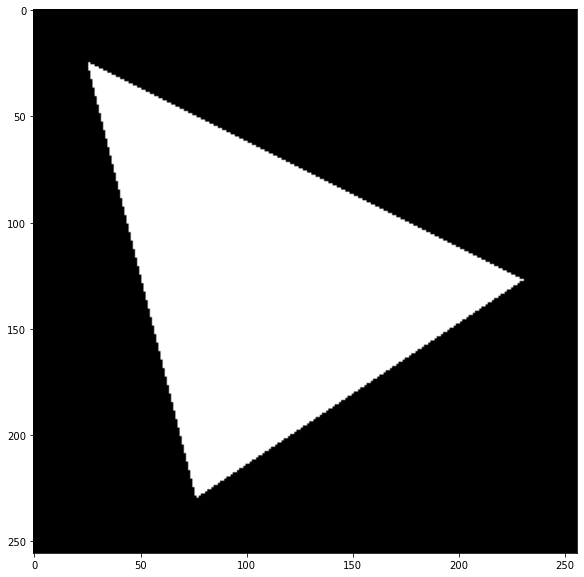

In [4]:
img = np.zeros(shape=(256, 256, 3))

t = np.array([[0.3, 0.1, 0.0],
             [0.9, 0.5, 0.0],
             [0.1, 0.9, 0.0]])

def get_triangle_pixels(p: np.ndarray):
    min_y = np.Inf
    max_y = -np.Inf
    min_i = -1
    max_i = -1
    rem_i = -1
    
    for i in range(3):
        if p[i, 1] < min_y:
            min_y = p[i, 1]
            min_i = i
        if p[i, 1] > max_y:
            max_y = p[i, 1]
            max_i = i
            
    for i in range(3):
        if i != min_i and i != max_i:
            rem_i = i
            break
    
    dp0 = p[max_i] - p[min_i]
    dp1 = p[rem_i] - p[min_i]
    
    if np.cross(dp1, dp0) > 0:
        dx = 1
    else:
        dx = -1
    
    fe = p[rem_i, 1]
    fsy = p[min_i, 1]
    fsx = p[min_i, 0]
    fr = dp1[0] / dp1[1] if dp1[1] > 0.000001 else np.Inf
    
    for pixel in get_line_pixels(p[min_i], p[max_i]):
        x = pixel[0]
        y = pixel[1]
        if fr == np.PINF or y > fe:
            dp = p[max_i] - p[rem_i]
            fe = p[max_i, 1]
            fsy = p[rem_i, 1]
            fsx = p[rem_i, 0]
            fr = dp[0] / dp[1] if dp[1] > 0.000001 else np.Inf
        
        if fr == np.Inf:
            break
        
        fx = fr * (y - fsy) + fsx
        while (dx > 0 and x < fx) or (dx < 0 and fx < x):
            yield np.array([x, y])
            x += dx

def draw_triangle(p: np.ndarray):
    for p in get_triangle_pixels(p):
        img[p[1], p[0], :] = 1.0

draw_triangle(t[:, :-1] * 256)
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])

## Vertex Parameter Interpolation

버텍스 파라미터(색, uv 등)를 interpolation 해보자.

우선은 단일 float 파라미터를 interpolation 해볼 것이다.

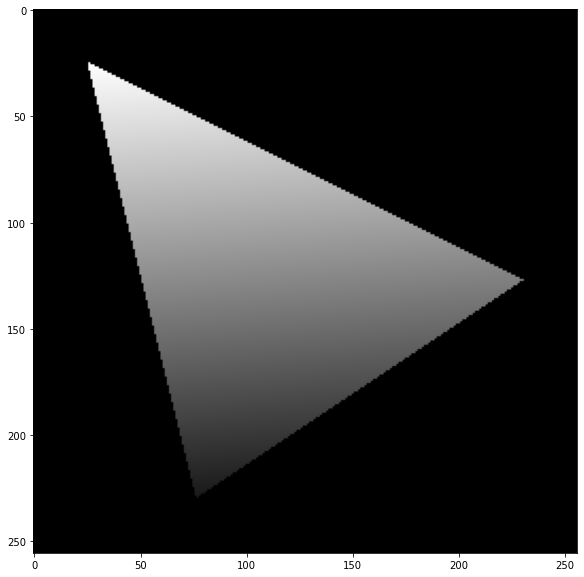

In [5]:
def draw_triangle(pos: np.ndarray, param: np.ndarray):
    m = np.zeros(shape=(2, 2))
    m[0, :] = pos[1] - pos[0]
    m[1, :] = pos[2] - pos[0]
    q = np.zeros(shape=(2, 1))
    q[0, 0] = param[1] - param[0]
    q[1, 0] = param[2] - param[0]
    c = np.linalg.inv(m) @ q
    
    for p in get_triangle_pixels(pos):
        val = c.T @ (p - pos[0]) + param[0]
        img[p[1], p[0], :] = val

draw_triangle(t[:, :-1] * 256, np.array([0.1, 0.5, 1.0]))
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])

단일 실수에 대해서는 위와 같은 공식으로 각 점의 값을 결정할 수 있지만,

parameter 수가 많은 경우에는 barycentric coordinate을 이용하면 더 효율적으로 interpolation 이 가능하다.

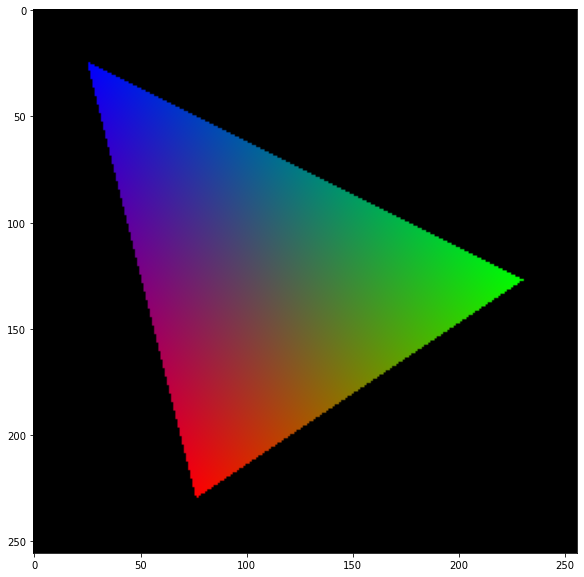

In [6]:
def f1(param):
    return param


def draw_triangle(pos: np.ndarray, param: np.ndarray, fragment_function):
    m = np.zeros(shape=(2, 2))
    m[0, :] = pos[1] - pos[0]
    m[1, :] = pos[2] - pos[0]
    q = np.zeros(shape=(2, 3))
    q[0, 0] = -1.0
    q[1, 0] = -1.0
    q[0, 1] = 1.0
    q[1, 1] = 0.0
    q[0, 2] = 0.0
    q[1, 2] = 1.0
    c = np.linalg.inv(m) @ q
    c = c.T
    b0 = np.array([1.0, 0.0, 0.0])
    
    for p in get_triangle_pixels(pos):
        b = c @ (p - pos[0]) + b0
        img[p[1], p[0], :] = np.clip(fragment_function(np.clip(param.T @ b, 0.0, 1.0)), 0.0, 1.0)

draw_triangle(t[:, :-1] * 256, np.array([[1.0, 0.0, 0.0],
                                        [0.0, 1.0, 0.0],
                                        [0.0, 0.0, 1.0]]), f1)
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])

## Perspective projection

랜더링 파이프라인에서 원근감을 주기 위해, 다음과 같은 projection matrix 를 사용한다.

$$ M_p = \begin{pmatrix}
n & 0 & 0 & 0 \\
0 & n & 0 & 0 \\
0 & 0 & n + f & -nf \\
0 & 0 & 1 & 0 \end{pmatrix} $$

이 행렬은 homogeneous coordinate 의 w coordinate 로 나머지 coordinate 을 나누는 operation 이 이후에

존재한다는 전제하에 원근 효과를 만들어낸다.

perspective 행렬을 적용한 이후,

$\left[ l, r \right], \left[ b, t \right], \left[ n, f \right] $ 범위의 영역을

normalized device coordinate 으로 옮기는 orthographic projection 을 곱하면,

perspective projection (공간의 형태는 꼭대기가 잘려나간 피라미드)가 완성된다.

$$ M_{ortho} = \begin{pmatrix}
2 \over {r - l} & 0 & 0 & -{{r + l} \over {r - l}} \\
0 & 2 \over {t - b} & 0 & -{{t + b} \over {t - b}} \\
0 & 0 & 2 \over {n - f} & -{{n + f} \over {n - f}} \\
0 & 0 & 0 & 1 \\
\end{pmatrix} $$

$$ M_{per} = M_{ortho} * M_{p} $$

이를 코드로 구현하고, 체스판을 원근감있게 랜더링해보자.

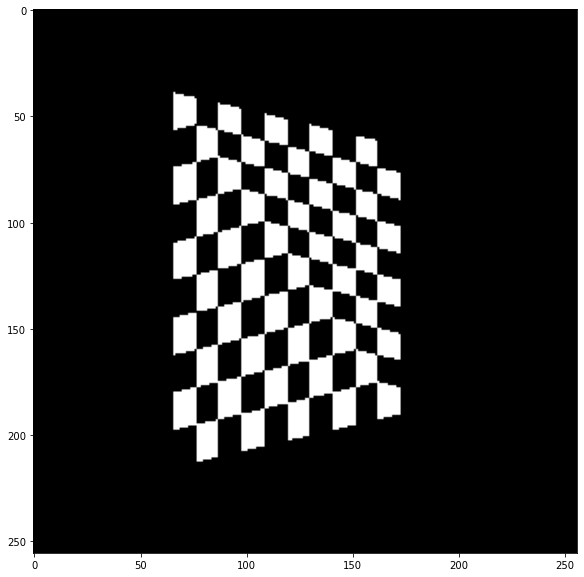

In [14]:
cam_pos = np.array([-2.0, 1.0, 3.0]) * 0.5
cam_target = np.array([0.5, 0.5, 0.0])
cam_up = np.array([0.0, 1.0, 0.0])
cam_z = cam_pos - cam_target
cam_z /= np.linalg.norm(cam_z)
cam_x = np.cross(cam_up, cam_z)
cam_x /= np.linalg.norm(cam_x)
cam_y = np.cross(cam_z, cam_x)
m_cam = np.zeros(shape=(4, 4))
m_cam[0:3, 0] = cam_x
m_cam[0:3, 1] = cam_y
m_cam[0:3, 2] = cam_z
m_cam[0:3, 3] = cam_pos
m_cam[3, 3] = 1.0
m_cam = np.linalg.inv(m_cam)

near = -1.0
far = -100.0

m_p = np.zeros(shape=(4, 4))
m_p[0, 0] = near
m_p[1, 1] = near
m_p[2, 2] = near + far
m_p[2, 3] = -1 * near * far
m_p[3, 2] = 1.0

cam_t = -near * np.deg2rad(47.0 * 0.5)
cam_b = -cam_t
cam_l = cam_b
cam_r = cam_t
cam_n = near
cam_f = far
m_ortho = np.zeros(shape=(4, 4))
m_ortho[0, 0] = 2.0 / (cam_r - cam_l)
m_ortho[0, 3] = -(cam_r + cam_l) / (cam_r - cam_l)
m_ortho[1, 1] = 2.0 / (cam_t - cam_b)
m_ortho[1, 3] = -(cam_t + cam_b) / (cam_t - cam_b)
m_ortho[2, 2] = 2.0 / (cam_n - cam_f)
m_ortho[2, 3] = -(cam_n + cam_f) / (cam_n - cam_f)
m_ortho[3, 3] = 1.0

m_vp = m_ortho @ m_p @ m_cam

img = np.zeros(shape=(256, 256, 3))

def project(pos):
    ndc = m_vp @ pos.T
    ndc = ndc.T
    ndc_w = ndc[:, 3].reshape(3,)
    ndc = (ndc / ndc_w[:, None]).T
    return ((ndc[0:2,:] + 1.0) * 0.5 * 256).T, ndc_w

def f1(param):
    color = np.floor(param / 0.1).astype(np.int32) % 2
    color = (color[0] + color[1]) % 2
    return np.ones(shape=(3,)) * color


t = np.zeros(shape=(3, 4))
t[0] = np.array([0.0, 0.0, 0.0, 1.0])
t[1] = np.array([1.0, 0.0, 0.0, 1.0])
t[2] = np.array([0.0, 1.0, 0.0, 1.0])
t1, z1 = project(t)
t[0] = np.array([0.0, 1.0, 0.0, 1.0])
t[1] = np.array([1.0, 0.0, 0.0, 1.0])
t[2] = np.array([1.0, 1.0, 0.0, 1.0])
t2, z2 = project(t)

draw_triangle(t1, np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]]), f1)
draw_triangle(t2, np.array([[0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]), f1)
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])

## Perspectively correct interpolation

위 코드의 결과를 보면 뭔가 맞지만, 뭔가가 틀리다는 점을 알 수 있다.

우리가 원하는 결과물은 원근감이 잘 적용된 체스판이지만,

위의 체스판은 그리드가 중간에 꺾여있다.

위와 같은 결과가 나온 이유는 world 상에서 linear 한 parameter 가 projection 을 거친 이후에는

더 이상 linear 하지 않기 때문이다.

자세한 내용은 다음의 문서를 참고하자.

https://www.comp.nus.edu.sg/~lowkl/publications/lowk_persp_interp_techrep.pdf

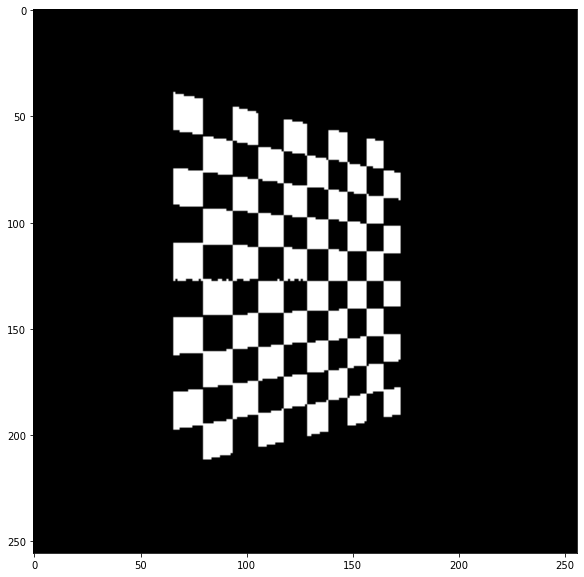

In [15]:
def draw_triangle(pos: np.ndarray, z: np.ndarray, param: np.ndarray, fragment_function):
    m = np.zeros(shape=(2, 2))
    m[0, :] = pos[1, 0:2] - pos[0, 0:2]
    m[1, :] = pos[2, 0:2] - pos[0, 0:2]
    q = np.zeros(shape=(2, 3))
    q[0, 0] = -1.0
    q[1, 0] = -1.0
    q[0, 1] = 1.0
    q[1, 1] = 0.0
    q[0, 2] = 0.0
    q[1, 2] = 1.0
    c = np.linalg.inv(m) @ q
    c = c.T
    b0 = np.array([1.0, 0.0, 0.0])
    inv_z = 1 / z
    
    for p in get_triangle_pixels(pos):
        b = c @ (p - pos[0, 0:2]) + b0
        b_z = 1 / (inv_z.T @ b)
        scale = inv_z * b_z
        b = b * scale
        img[p[1], p[0], :] = np.clip(fragment_function(np.clip(param.T @ b, 0.0, 1.0)), 0.0, 1.0)

draw_triangle(t1, z1, np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]]), f1)
draw_triangle(t2, z2, np.array([[0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]), f1)
plt.figure(figsize = (10, 10))
plt.imshow(img[::-1, :, :])